In [ ]:
Standart kütüphanelere ek olarak, bu sefer Scikit-Learn kütüphanesinde 
olmayan, harici bir kütüphane olan XGBoost'u (eXtreme Gradient Boosting) yüklememiz gerekiyor.

In [10]:
# 1. XGBoost Kütüphanesinin Yüklenmesi
# Bu komut, Jupyter Notebook içerisinden terminal komutu çalıştırmamızı sağlar.
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Bagging (Torbalama) ve XGBoost (Boosting) algoritmaları
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
Veriyi yüklüyor ve klasik eğitim/test ayrımını yapıyoruz. Not: XGBoost, sadece 
sayısal verilerle çalışmayı sever, bu yüzden verimizin temiz ve encode edilmiş 
olması (cleaned_weather_vize.csv) çok önemlidir.

In [12]:
# Veriyi yükle
data = pd.read_csv('cleaned_weather_vize.csv')

# Hedef ve Öznitelik ayrımı
X = data.drop(['RainTomorrow'], axis=1)
y = data['RainTomorrow']

# Eğitim ve Test setlerine ayırma (%80 - %20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim Seti: {X_train.shape}")
print(f"Test Seti: {X_test.shape}")

Eğitim Seti: (116368, 22)
Test Seti: (29092, 22)


In [ ]:
İlk gelişmiş modelimiz Bagging.

Mantık: Tek bir Karar Ağacına güvenmek yerine, verinin farklı parçalarıyla eğitilmiş 50 tane ağaç (n_estimators=50) kuruyoruz.

Farkı: Random Forest'tan farklı olarak, burada temel tahminciyi (base_estimator) kendimiz seçebiliriz (Burada DecisionTree seçilmiş).

In [14]:
print("Model 1 Eğitiliyor: Bagging Classifier...")

# DÜZELTME: 'base_estimator' yerine 'estimator' yazıyoruz.
bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(),
                              n_estimators=50,
                              random_state=42)

bag_model.fit(X_train, y_train)

# Tahmin ve Sonuç
y_pred_bag = bag_model.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)

print(f">>> Bagging Accuracy: {acc_bag:.4f}")
print(classification_report(y_test, y_pred_bag))

Model 1 Eğitiliyor: Bagging Classifier...
>>> Bagging Accuracy: 0.8555
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22717
           1       0.75      0.52      0.61      6375

    accuracy                           0.86     29092
   macro avg       0.81      0.73      0.76     29092
weighted avg       0.85      0.86      0.85     29092



In [ ]:
İkinci ve en güçlü modelimiz XGBoost.

Mantık: Bagging ağaçları paralel (bağımsız) eğitirken, Boosting ağaçları seri (sıralı) eğitir.

Çalışma Prensibi: İlk ağacın yaptığı hatayı ikinci ağaç düzeltmeye çalışır, ikincinin hatasını üçüncü düzeltir... Bu zincirleme reaksiyon, hatayı minimuma indirir.

eval_metric='logloss': Modelin başarısını ölçerken "Logaritmik Kayıp" fonksiyonunu kullanır.

In [15]:
print("\nModel 2 Eğitiliyor: XGBoost (Boosting)...")

# XGBoost Modeli
xgb_model = XGBClassifier(use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42)

xgb_model.fit(X_train, y_train)

# Tahmin ve Sonuç
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print(f">>> XGBoost Accuracy: {acc_xgb:.4f}")
print(classification_report(y_test, y_pred_xgb))


Model 2 Eğitiliyor: XGBoost (Boosting)...
>>> XGBoost Accuracy: 0.8613
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22717
           1       0.75      0.55      0.64      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.75      0.78     29092
weighted avg       0.85      0.86      0.85     29092



In [ ]:
XGBoost'un en güzel yanlarından biri, hangi hava durumu olayının yağmuru daha çok tetiklediğini bize puanlayarak vermesidir.

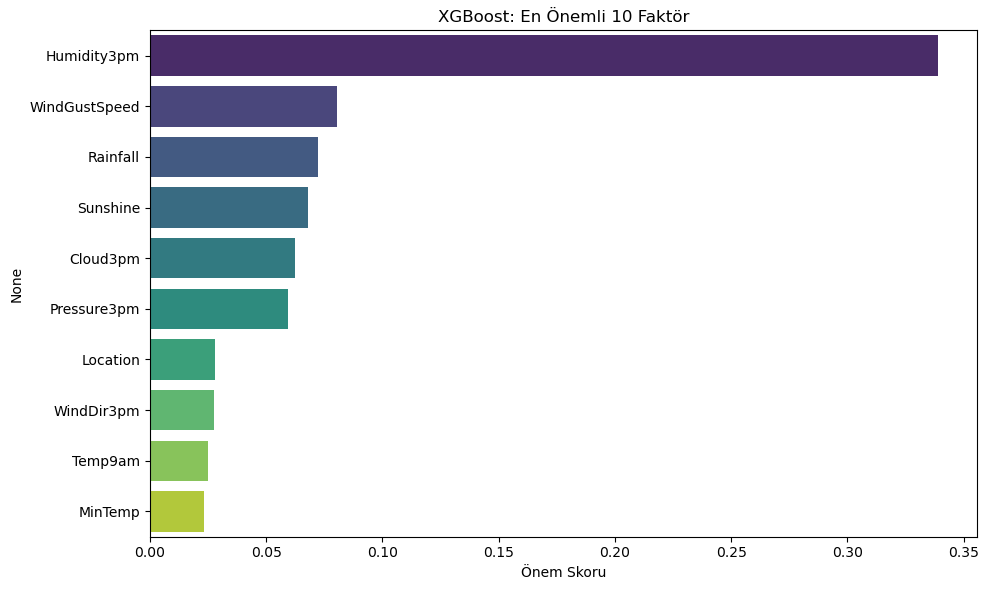

In [16]:
# GÖRSEL 1: Feature Importance (XGBoost)
# Özelliklerin önem derecelerini çekiyoruz
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(10), y=importances.head(10).index, palette='viridis', legend=False)

plt.title('XGBoost: En Önemli 10 Faktör')
plt.xlabel('Önem Skoru')
plt.tight_layout()
plt.show()

In [ ]:
Son olarak, iki algoritmayı karşılaştırıyoruz. Hangi mimari daha başarılı oldu?

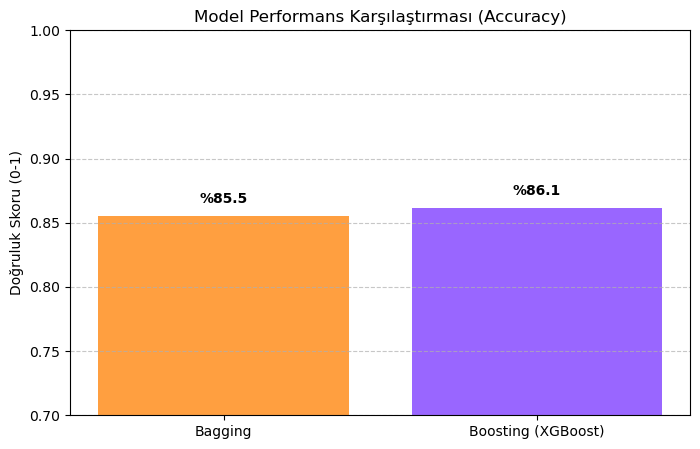

In [17]:
# GÖRSEL 2: Bagging vs Boosting Karşılaştırması
plt.figure(figsize=(8, 5))
models = ['Bagging', 'Boosting (XGBoost)']
accuracies = [acc_bag, acc_xgb]

# Çubuk grafiği (Turuncu ve Mor renkler)
bars = plt.bar(models, accuracies, color=['#FF9F40', '#9966FF'])

# Çubukların üzerine oranları yazdıralım
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"%{yval*100:.1f}", ha='center', fontweight='bold')

plt.title('Model Performans Karşılaştırması (Accuracy)')
plt.ylabel('Doğruluk Skoru (0-1)')
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [1]:
"" !pip install xgboost

Model 1 Eğitiliyor: Bagging Classifier...

>>> Bagging Accuracy: 0.8555
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22717
           1       0.75      0.52      0.61      6375

    accuracy                           0.86     29092
   macro avg       0.81      0.73      0.76     29092
weighted avg       0.85      0.86      0.85     29092


Model 2 Eğitiliyor: XGBoost (Boosting)...

>>> XGBoost Accuracy: 0.8613
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22717
           1       0.75      0.55      0.64      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.75      0.78     29092
weighted avg       0.85      0.86      0.85     29092



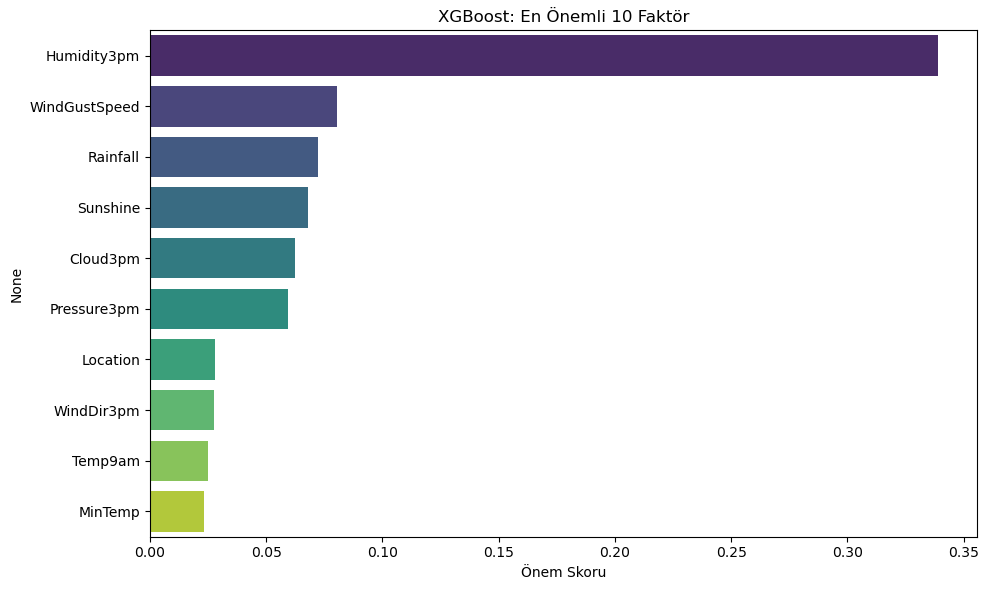

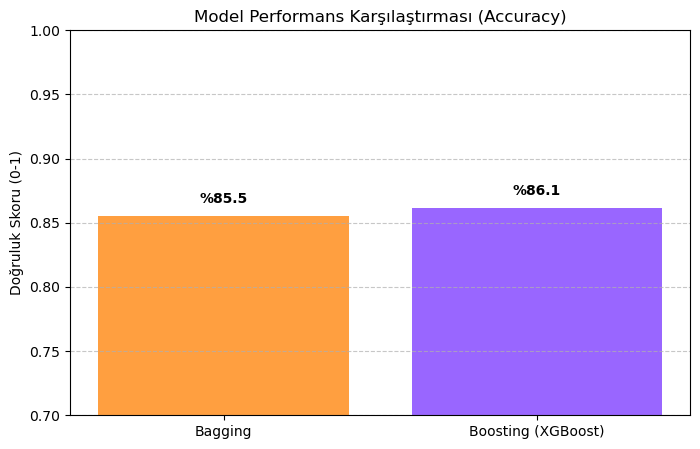

In [6]:
"""
# --- EMRE_SOMER_CABAK_22040101027_TeamShinningStars.ipynb ---
# Algoritmalar: Bagging Classifier ve Boosting (XGBoost)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Veri Yükle
df = pd.read_csv('cleaned_weather_vize.csv')
if 'RISK_MM' in df.columns: df.drop('RISK_MM', axis=1, inplace=True)

# 2. Veri Ayırma
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- MODEL 1: BAGGING ---
print("Model 1 Eğitiliyor: Bagging Classifier...")
bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bag_model.fit(X_train, y_train)
y_pred_bag = bag_model.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)

print(f"\n>>> Bagging Accuracy: {acc_bag:.4f}")
print(classification_report(y_test, y_pred_bag))

# --- MODEL 2: BOOSTING (XGBoost) ---
print("\nModel 2 Eğitiliyor: XGBoost (Boosting)...")
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"\n>>> XGBoost Accuracy: {acc_xgb:.4f}")
print(classification_report(y_test, y_pred_xgb))

# GÖRSEL 1: Feature Importance (XGBoost)
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, hue=importances.index, palette='viridis', legend=False)
plt.title('XGBoost: En Önemli 10 Faktör')
plt.xlabel('Önem Skoru')
plt.tight_layout()
plt.show()

# GÖRSEL 2: Bagging vs Boosting Karşılaştırması
plt.figure(figsize=(8, 5))
models = ['Bagging', 'Boosting (XGBoost)']
accuracies = [acc_bag, acc_xgb]


bars = plt.bar(models, accuracies, color=['#FF9F40', '#9966FF']) # Turuncu ve Mor renkler

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"%{yval*100:.1f}", ha='center', fontweight='bold')

plt.title('Model Performans Karşılaştırması (Accuracy)')
plt.ylabel('Doğruluk Skoru (0-1)')
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
"""